In [31]:
# !pip install ccxt scikit-learn pandas numpy matplotlib seaborn mplfinance ipywidgets # tensorflow

In [32]:
import ccxt
import talib
import numpy as np
import pandas as pd
import mplfinance as mpf
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
import mplfinance as mpf
from IPython.display import display


In [33]:
exchange = ccxt.binance({'enableRateLimit': True,})
symbol = 'XRP/USDT:USDT'
timeframe = '1m'
limit = 250

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(df.tail())

                       open    high     low   close    volume
timestamp                                                    
2025-10-24 20:50:00  2.5093  2.5109  2.5088  2.5091  598085.0
2025-10-24 20:51:00  2.5091  2.5091  2.5058  2.5059  150753.2
2025-10-24 20:52:00  2.5058  2.5087  2.5052  2.5068  515482.1
2025-10-24 20:53:00  2.5067  2.5101  2.5062  2.5093  466890.5
2025-10-24 20:54:00  2.5092  2.5092  2.5090  2.5091    8734.5


In [34]:
df['MAX']      = talib.MAX(df['close'], timeperiod=14)
df['MIN']      = talib.MIN(df['close'], timeperiod=14)
df['RSI']      = talib.RSI(df['close'], timeperiod=14)
df['DX']       = talib.DX(df['high'], df['low'], df['close'], timeperiod=14)
df['ADX']      = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
df['ADXR']     = talib.ADXR(df['high'], df['low'], df['close'], timeperiod=14)
df['TRANGE']   = talib.TRANGE(df['high'], df['low'], df['close'])
df['ATR']      = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
df['MFI']      = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df['PLUS_DI']  = talib.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df['OBV']      = talib.OBV(df['close'], df['volume'])
df['STDDEV']   = talib.STDDEV(df['close'], timeperiod=14, nbdev=1)

df.dropna(inplace=True)

print(df.tail())

                       open    high     low   close    volume     MAX     MIN  \
timestamp                                                                       
2025-10-24 20:50:00  2.5093  2.5109  2.5088  2.5091  598085.0  2.5093  2.5006   
2025-10-24 20:51:00  2.5091  2.5091  2.5058  2.5059  150753.2  2.5093  2.5006   
2025-10-24 20:52:00  2.5058  2.5087  2.5052  2.5068  515482.1  2.5093  2.5012   
2025-10-24 20:53:00  2.5067  2.5101  2.5062  2.5093  466890.5  2.5093  2.5020   
2025-10-24 20:54:00  2.5092  2.5092  2.5090  2.5091    8734.5  2.5093  2.5020   

                           RSI         DX        ADX       ADXR  TRANGE  \
timestamp                                                                 
2025-10-24 20:50:00  61.771126  28.929988  17.816602  17.947574  0.0021   
2025-10-24 20:51:00  51.109828   8.438731  17.146754  17.432489  0.0033   
2025-10-24 20:52:00  53.538639   4.849546  16.268382  17.090603  0.0035   
2025-10-24 20:53:00  59.550001  12.155664  15.974617  16.

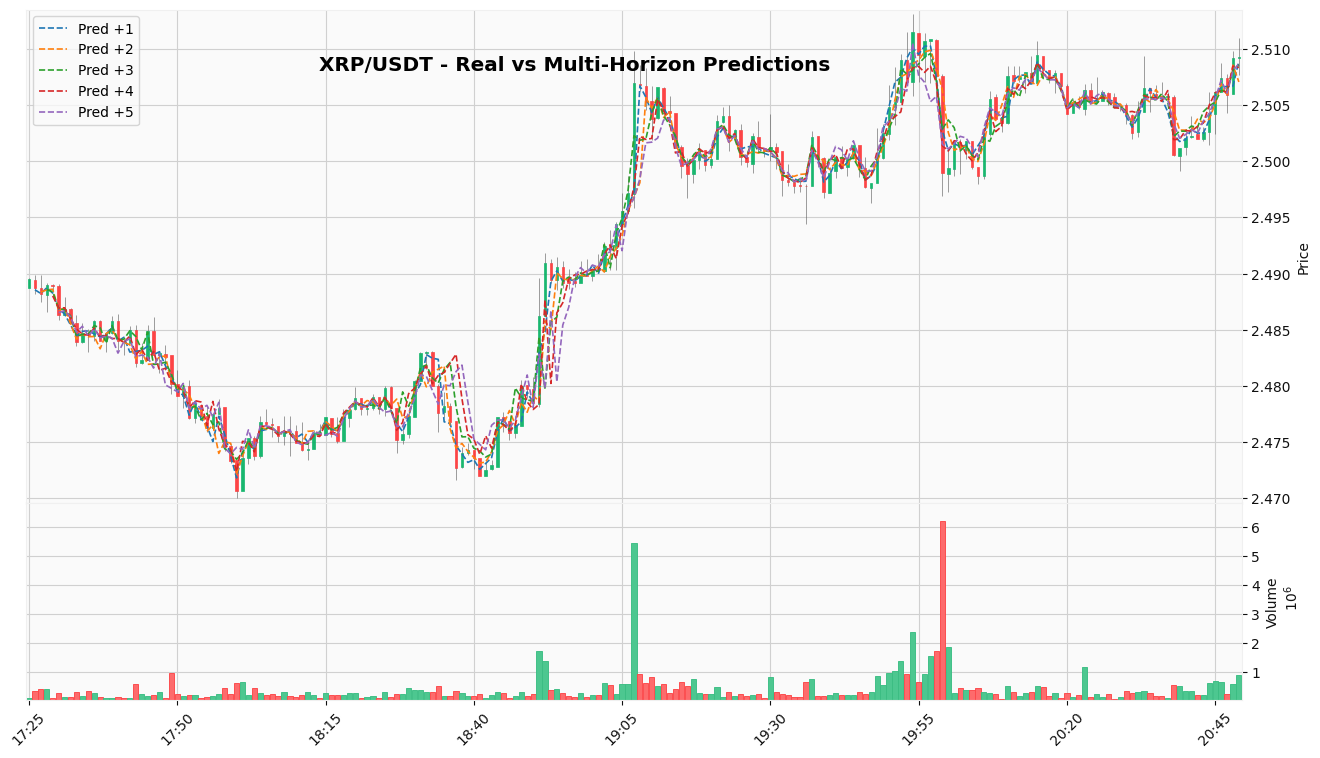

In [35]:
for i in range(1, 6):
    df[f'close_future_{i}'] = df['close'].shift(-i)

df.dropna(inplace=True)

feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'MAX', 'MIN', 'RSI', 'DX', 'ADX', 'ADXR',
    'TRANGE', 'ATR', 'MFI', 'MINUS_DI', 'PLUS_DI',
    'OBV', 'STDDEV'
]
features = df[feature_cols]
targets = df[[f'close_future_{i}' for i in range(1, 6)]]

X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred_all = model.predict(features)

pred_cols = [f'pred_close_future_{i}' for i in range(1, 6)]
df_pred_all = pd.DataFrame(pred_all, columns=pred_cols, index=df.index)

df_full = pd.concat([df, df_pred_all], axis=1)

addplots = []
for i in range(1, 6):
    src_col = f'pred_close_future_{i}'
    plot_col = f'{src_col}_at_t_plus_{i}'
    df_full[plot_col] = df_full[src_col].shift(i)
    addplots.append(
        mpf.make_addplot(
            df_full[plot_col],
            type='line',
            width=1.2,
            linestyle='--',
            panel=0,
            secondary_y=False,
            label=f'Pred +{i}'
        )
    )

mpf.plot(
    df_full,
    type='candle',
    style='yahoo',
    volume=True,
    addplot=addplots,
    title='XRP/USDT - Real vs Multi-Horizon Predictions',
    ylabel='Price',
    ylabel_lower='Volume',
    figsize=(14, 8),
    tight_layout=True,
)
